## **Final Project:**



# *Machine Learning with Bioinformatics*
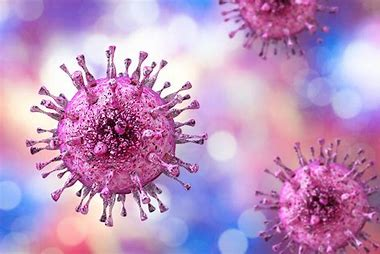

#Code Written By:
*   **Kelsey Woods**
> Bioinformatician (UMASS Medical School)
> & MS Data Science Candidate
*   **Aayushi Verma**
> Data Scientist
> & MS Data Science Candidate

#Topic:
* Cytomegalovirus (CMV) is a common infection caused by a type of herpes virus. Pregnant people infected with CMV can give birth to a baby with congenital CMV. Congenital CMV can cause hearing loss and developmental issues. CMV can cause serious complications in people who have a compromised immune system, such as transplant recipients.
* Macaca mulatta, also known as Rhesus Monkey is the best comparison we can make to human infection, because there is not model organism for CMV

#Data Preparation

Below: I am importing a reference sequence from my lab at UMASS Medical School. It is available on GenBank if anyone else would like to play with it!

In [1]:
!pip install sgt
import sgt
sgt.__version__
from sgt import SGT
!pip install pandarallel
import pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 1.2 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.4-py3-none-any.whl size=16677 sha256=d7d3799b61b79e12418276b7b6f54c25cc68054da387489162afbe0e967af236
  Stored in directory: /root/.cache/pip/wheels/80/3a/18/ad02ff58953d0aea45e4f30682a40974b336626a50fe4a2f90
Successfully built pandarallel


In [2]:
from sgt import SGT

import numpy as np
import pandas as pd
from itertools import chain
from itertools import product as iterproduct
import warnings

import pickle

########
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
import time

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(7) # fix random seed for reproducibility

# from sgt import Sgt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd

corpus = pd.read_csv('/content/drive/MyDrive/Bioinformatic/finalSeq - TotalSeq.csv')

# Data preprocessing
corpus = corpus.loc[:,['id','sequence']]
corpus.columns = ['id', 'sequence']
corpus['sequence'] = corpus['sequence'].map(list)
corpus

,id,sequence
0,NC_006273.2 Human herpesvirus 5 strain Merlin,"[M, P, A, T, D, T, N, S, T, H, T, T, P, L, H, ..."
1,NC_016154.1 Cynomolgus macaque cytomegalovirus...,"[M, F, Y, N, P, Y, L, G, G, G, R, R, A, A, P, ..."
2,U76749.1 Rhesus cytomegalovirus glycoprotein B...,"[M, L, L, L, I, P, P, S, F, A, F, P, L, H, S, ..."


In [7]:
%%time
# Compute SGT embeddings
sgt_ = SGT(kappa=1, 
           lengthsensitive=False, 
           mode='multiprocessing')
sgtembedding_df = sgt_.fit_transform(corpus)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 49.5 ms, sys: 44.4 ms, total: 94 ms
Wall time: 543 ms


In [8]:
sgtembedding_df

,id,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
0,NC_006273.2 Human herpesvirus 5 strain Merlin,0.004005,0.007417,0.011125,0.006520,0.001701,0.002083,0.004278,0.001453,0.001515,...,2.957186e-12,5.691045e-03,0.008781,0.004684,0.000173,0.000007,0.000621,0.005524,1.951844e-07,0.000006
1,NC_016154.1 Cynomolgus macaque cytomegalovirus...,0.002213,0.000780,0.001107,0.001339,0.000664,0.001666,0.001352,0.001331,0.001240,...,1.791045e-04,1.902742e-03,0.000903,0.001403,0.001445,0.000534,0.001518,0.000877,4.415747e-06,0.000566
2,U76749.1 Rhesus cytomegalovirus glycoprotein B...,0.002163,0.005346,0.001912,0.003491,0.002926,0.000631,0.002655,0.000729,0.002827,...,2.437618e-02,4.377753e-07,0.002062,0.000178,0.002093,0.002584,0.001057,0.000086,1.332723e-08,0.003498


In [9]:
sgtembedding_df = sgtembedding_df.set_index('id')
sgtembedding_df

,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,
NC_006273.2 Human herpesvirus 5 strain Merlin,0.004005,0.007417,0.011125,0.006520,0.001701,0.002083,0.004278,0.001453,0.001515,0.002081,...,2.957186e-12,5.691045e-03,0.008781,0.004684,0.000173,0.000007,0.000621,0.005524,1.951844e-07,0.000006
NC_016154.1 Cynomolgus macaque cytomegalovirus strain Ottawa,0.002213,0.000780,0.001107,0.001339,0.000664,0.001666,0.001352,0.001331,0.001240,0.001233,...,1.791045e-04,1.902742e-03,0.000903,0.001403,0.001445,0.000534,0.001518,0.000877,4.415747e-06,0.000566
U76749.1 Rhesus cytomegalovirus glycoprotein B gene,0.002163,0.005346,0.001912,0.003491,0.002926,0.000631,0.002655,0.000729,0.002827,0.002614,...,2.437618e-02,4.377753e-07,0.002062,0.000178,0.002093,0.002584,0.001057,0.000086,1.332723e-08,0.003498


In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(sgtembedding_df)

X=pca.transform(sgtembedding_df)

print(np.sum(pca.explained_variance_ratio_))
df = pd.DataFrame(data=X, columns=['x1', 'x2'])
df.head()

0.9999999999999999


,x1,x2
0,0.072580,-0.000462
1,-0.037115,-0.030265
2,-0.035466,0.030727


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


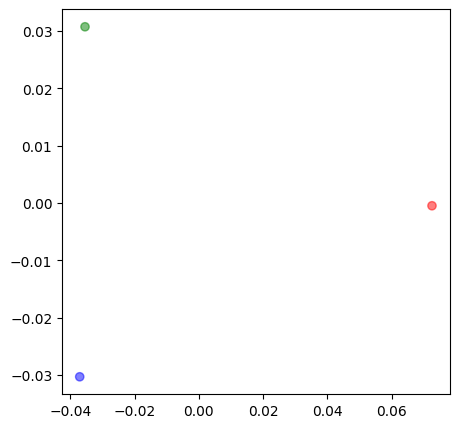

In [11]:
kmeans = KMeans(n_clusters=3, max_iter =300)
kmeans.fit(df)

labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(5, 5))
colmap = {1: 'r', 2: 'g', 3: 'b'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df['x1'], df['x2'], color=colors, alpha=0.5, edgecolor=colors)

##Source Code from Github for SGT package

In [12]:
import numpy as np
import pandas as pd
from itertools import chain
from itertools import product as iterproduct
import warnings

class SGT():
    '''
    Compute embedding of a single or a collection of discrete item
    sequences. A discrete item sequence is a sequence made from a set
    discrete elements, also known as alphabet set. For example,
    suppose the alphabet set is the set of roman letters,
    {A, B, ..., Z}. This set is made of discrete elements. Examples of
    sequences from such a set are AABADDSA, UADSFJPFFFOIHOUGD, etc.
    Such sequence datasets are commonly found in online industry,
    for example, item purchase history, where the alphabet set is
    the set of all product items. Sequence datasets are abundant in
    bioinformatics as protein sequences.
    Using the embeddings created here, classification and clustering
    models can be built for sequence datasets.
    Read more in https://arxiv.org/pdf/1608.03533.pdf
    Parameters
    ----------
    Input
    alphabets       Optional, except if mode is Spark.
                    The set of alphabets that make up all
                    the sequences in the dataset. If not passed, the
                    alphabet set is automatically computed as the
                    unique set of elements that make all the sequences.
                    A list or 1d-array of the set of elements that make up the
                    sequences. For example, np.array(["A", "B", "C"].
                    If mode is 'spark', the alphabets are necessary.
    kappa           Tuning parameter, kappa > 0, to change the extraction of
                    long-term dependency. Higher the value the lesser
                    the long-term dependency captured in the embedding.
                    Typical values for kappa are 1, 5, 10.
    lengthsensitive Default False. This is set to true if the embedding of
                    should have the information of the length of the sequence.
                    If set to false then the embedding of two sequences with
                    similar pattern but different lengths will be the same.
                    lengthsensitive = false is similar to length-normalization.
    flatten         Default True. If True the SGT embedding is flattened and returned as
                    a vector. Otherwise, it is returned as a matrix with the row and col
                    names same as the alphabets. The matrix form is used for
                    interpretation purposes. Especially, to understand how the alphabets
                    are "related". Otherwise, for applying machine learning or deep
                    learning algorithms, the embedding vectors are required.
    mode            Choices in {'default', 'multiprocessing'}.
    processors      Used if mode is 'multiprocessing'. By default, the
                    number of processors used in multiprocessing is
                    number of available - 1.
    '''

    def __init__(self,
                 alphabets=[],
                 kappa=1,
                 lengthsensitive=False,
                 flatten=True,
                 mode='default',
                 processors=None,
                 lazy=False):

        self.alphabets = alphabets
        
        if len(self.alphabets) != 0:
            self.feature_names = self.__set_feature_names(self.alphabets)
        
        self.kappa = kappa
        self.lengthsensitive = lengthsensitive
        self.flatten = flatten
        self.mode = mode
        self.processors = processors

        if self.processors==None:
            import os
            self.processors = os.cpu_count() - 1

        self.lazy = lazy

    def getpositions(self, sequence, alphabets):
        '''
        Compute index position elements in the sequence
        given alphabets set.
        Return list of tuples [(value, position)]
        '''
        positions = [(v, np.where(sequence == v))
                     for v in alphabets if v in sequence]

        return positions

    def fit(self, sequence):
        '''
        Extract Sequence Graph Transform features using Algorithm-2.
        sequence            An array of discrete elements. For example,
                            np.array(["B","B","A","C","A","C","A","A","B","A"].
        return: sgt matrix or vector (depending on Flatten==False or True)
        '''

        sequence = np.array(sequence)

        if(len(self.alphabets) == 0):
            self.alphabets = self.estimate_alphabets(sequence)
            self.feature_names = self.__set_feature_names(self.alphabets)
            
        size = len(self.alphabets)
        l = 0
        W0, Wk = np.zeros((size, size)), np.zeros((size, size))
        positions = self.getpositions(sequence, self.alphabets)

        alphabets_in_sequence = np.unique(sequence)

        for i, u in enumerate(alphabets_in_sequence):
            index = [p[0] for p in positions].index(u)

            U = np.array(positions[index][1]).ravel()

            for j, v in enumerate(alphabets_in_sequence):
                index = [p[0] for p in positions].index(v)

                V2 = np.array(positions[index][1]).ravel()

                C = [(i, j) for i in U for j in V2 if j > i]

                cu = np.array([ic[0] for ic in C])
                cv = np.array([ic[1] for ic in C])

                # Insertion positions
                pos_i = self.alphabets.index(u)
                pos_j = self.alphabets.index(v)

                W0[pos_i, pos_j] = len(C)

                Wk[pos_i, pos_j] = np.sum(np.exp(-self.kappa * np.abs(cu - cv)))

            l += U.shape[0]

        if self.lengthsensitive:
            W0 /= l

        W0[np.where(W0 == 0)] = 1e7  # avoid divide by 0

        sgt = np.power(np.divide(Wk, W0), 1/self.kappa)

        if(self.flatten):
            sgt = pd.Series(sgt.flatten(), index=self.feature_names)
        else:
            sgt = pd.DataFrame(sgt, 
                               columns=self.alphabets, 
                               index=self.alphabets)
        return sgt

    def __flatten(self, listOfLists):
        "Flatten one level of nesting"
        flat = [x for sublist in listOfLists for x in sublist]
        return flat

    def estimate_alphabets(self, corpus):
        if len(corpus) > 1e5:
            print("Error: Too many sequences. Pass the alphabet list as an input. Exiting.")
            sys.exit(1)
        else:
            return(np.unique(np.asarray(self.__flatten(corpus))).tolist())

    def set_alphabets(self, corpus):
        self.alphabets = self.estimate_alphabets(corpus)
        self.feature_names = self.__set_feature_names(self.alphabets)
        return self

    def get_alphabets(self):
        return self.alphabets
    
    def get_feature_names(self):
        return self.feature_names

    def __fit_to_list(self, sequence):
        return list(self.fit(sequence))

    def __set_feature_names(self, alphabets):
        return list(iterproduct(alphabets, alphabets))

    def fit_transform(self, corpus):
        '''
        Inputs:
        corpus       A list of sequences. Each sequence is a list of alphabets.
        '''

        if(len(self.alphabets) == 0):
            self.alphabets = self.estimate_alphabets(corpus['sequence'])
            self.feature_names = self.__set_feature_names(self.alphabets)

        if self.mode=='default':
            sgt = corpus.apply(lambda x: [x['id']] + list(self.fit(x['sequence'])), 
                               axis=1, 
                               result_type='expand')
            sgt.columns = ['id'] + self.feature_names
            return sgt
        elif self.mode=='multiprocessing':
            # Import
            from pandarallel import pandarallel
            # Initialization
            pandarallel.initialize(nb_workers=self.processors)
            sgt = corpus.parallel_apply(lambda x: [x['id']] + 
                                        list(self.fit(x['sequence'])), 
                                        axis=1, 
                                        result_type='expand')
            sgt.columns = ['id'] + self.feature_names            
            return sgt
    
    def transform(self, corpus):
        '''
        Inputs:
        corpus       A list of sequences. Each sequence is a list of alphabets.
        '''
        
        '''
        Difference between fit_transform and transform is:
        In transform() we have the alphabets already  known.
        In fit_transform() is alphabets are not known, they
        are computed.
        The computation in fit is essentially getting the
        alphabets set.
        '''

        if self.mode=='default':
            sgt = corpus.apply(lambda x: [x['id']] + list(self.fit(x['sequence'])), 
                               axis=1, 
                               result_type='expand')
            sgt.columns = ['id'] + self.feature_names
            return sgt
        elif self.mode=='multiprocessing':
            # Import
            from pandarallel import pandarallel
            # Initialization
            pandarallel.initialize(nb_workers=self.processors)
            sgt = corpus.parallel_apply(lambda x: [x['id']] + 
                                        list(self.fit(x['sequence'])), 
                                        axis=1, 
                                        result_type='expand')
            sgt.columns = ['id'] + self.feature_names            
            return sgt

##What is SGT?

The SGT algorithm, which stands for Spectrum-based Graph Kernels, is an algorithm that computes similarity scores based on the similarity of graph spectra, which is the disctribution of eigenvalues of the graphs' Laplacian matrices. The SGT algorithm works like this:

1. Compute the Laplacian matrices of two graphs.
2. Compute the eigendecomposition of the Laplacian matrices to obtain corresponding eigenvalues and eigenvectors.
3. Compute the normalized eigenvector dot product between the two graphs' corresponding eigenvalues to obtain the similarity score.
4. Repeat steps 1-3 for all pairs of graphs in the dataset to obtain a graph similarity matrix.

The SGT algorithm can be applied to a variety of types of graphs. It is used very widely in the bioinformatics field, and some applications of the algorithm include for molecular graphs, protein structures, social networks, and more.

There is a Python package, SGT bioinformatics, that implements the SGT algorithm.